In [16]:
import pandas as pd                                     # type: ignore
import numpy as np                                      # type: ignore
import warnings                                         # type: ignore
from sklearn.model_selection import train_test_split    # type: ignore
from sklearn.decomposition import PCA                   # type: ignore
from sklearn.preprocessing import StandardScaler, MinMaxScaler# type: ignore
from sklearn.model_selection import GridSearchCV, KFold # type: ignore
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve# type: ignore
import tensorflow as tf                                 # type: ignore
from tensorflow import keras                            # type: ignore
from keras.layers import Dense, Dropout                 # type: ignore
from keras.optimizers import Adam, SGD                  # type: ignore
from keras.callbacks import EarlyStopping               # type: ignore
import matplotlib.pyplot as plt                         # type: ignore
from imblearn.over_sampling import RandomOverSampler, SMOTE# type: ignore
from imblearn.under_sampling import TomekLinks          # type: ignore

warnings.filterwarnings(action='ignore')

tf.config.set_visible_devices([], 'GPU')

In [17]:
# GPU 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [30]:
class DNNModel:
    def __init__(self) -> None:
        self.model = None
        self.df = None
        self.x_train = None
        self.y_train = None
        self.input_dim = 0
        self.model_name = ""

    def load_file(self, file_path:str)->None:
        self.df = pd.read_csv(file_path)
        x_train = self.df.drop(columns=['loan_status', 'Unnamed: 0'])
        y_train = self.df['loan_status']
        nan_indices = np.isnan(x_train).any(axis=1)
        self.x_train = x_train[~nan_indices]
        self.y_train = y_train[~nan_indices]
    
    def __get_n_components_from_pca(self, scaled_data:pd.DataFrame, threshold:float) -> int:
        pca = PCA()
        pca.fit(scaled_data)
        explained_variance = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance)
        n_components = np.argmax(cumulative_explained_variance >= threshold) + 1
        return n_components
    
    def scaling_data(
            self, 
            scaler:MinMaxScaler|StandardScaler=StandardScaler, 
            threshold:float=0.95, 
            over_sampler:SMOTE|RandomOverSampler=None, 
            under_sampler:TomekLinks=None)->None:
        x_scaled = scaler().fit_transform(self.x_train)
        self.input_dim = self.__get_n_components_from_pca(x_scaled, threshold=threshold)
        self.model_name+=('scaler:'+scaler.__name__+'_pca:'+str(int(threshold*100))+'_input:'+str(self.input_dim))
        self.x_train = PCA(n_components=self.input_dim).fit_transform(x_scaled).astype('float32')
        if over_sampler!=None:
            os = over_sampler(random_state=30)
            self.x_train, self.y_train = os.fit_resample(self.x_train,self.y_train)
            self.model_name+='_sampler:'+os.__class__.__name__
        elif under_sampler!=None:
            us = under_sampler(random_state=30, sampling_strategy='majority')
            self.x_train, self.y_train = us.fit_resample(self.x_train, self.y_train)
            self.model_name+='_sampler:'+us.__class__.__name__
        self.x_train, self.x_validation, self.y_train, self.y_validation = train_test_split(self.x_train, self.y_train, test_size=0.2, stratify=self.y_train, random_state=30)
    
    def __build_model(self, num_layers, num_nodes, loss)->keras.Sequential:
        # Define and compile the model
        model = keras.Sequential()
        model.add(Dense(num_nodes, input_dim=self.input_dim, activation='relu'))
        for _ in range(num_layers):
            model.add(Dense(num_nodes, activation='relu'))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='Adam', loss=loss, metrics=["accuracy"])
        return model
    
    def searching_best_param_grid(
            self, 
            grid_params:dict,
            params:dict={'min_delta':0.001, "n_splits":5},
            scoring='accuracy'
            ):
        kfold = KFold(random_state=30,
                n_splits=params['n_splits'],
                shuffle=True
                )
        model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=self.__build_model)
        # GridSearchCV 생성
        grid_search = GridSearchCV(estimator = model,
                                param_grid = grid_params,
                                cv = kfold,
                                scoring=scoring)
        early_stopping = EarlyStopping(monitor='loss',min_delta=params['min_delta'])
        # GridSearchCV fit 시작
        grid_search.fit(self.x_train, self.y_train, callbacks=[early_stopping])
        # 최적의 param
        print(f"Best params: {grid_search.best_params_}")
        # 최적의 param일 경우 최적의 accuracy
        print(f"Best average accuracy: {grid_search.best_score_}")
        return grid_search.best_params_, grid_search.best_score_
    
    def build_model_with_best_params(
            self, 
            best_params:dict, 
            params:dict={'min_delta':0.001, "n_splits":5}, 
            threshold:float=0.5)->dict:
        valid_accs, valid_f1s, valid_recalls, valid_precisions = [], [], [], []
        result_dict = {
                       'average validation accuracy':0,
                       'average validation recall':0,
                       'average validation precision':0,
                       'average validation f1':0,
                       'validation accuracy':0,
                       'validation recall':0,
                       'validation precision':0,
                       'validation f1':0,
                       }
        y_train_reshaped = np.reshape(self.y_train,(-1))
        model = self.__build_model(best_params['num_layers'], best_params['num_nodes'], best_params['loss'])
        kf = KFold(n_splits=params['n_splits'], shuffle=True, random_state=30)
        early_stopping = EarlyStopping(monitor='loss',min_delta=params['min_delta'])
        for train_index, val_index in kf.split(self.x_train, y_train_reshaped):
            X_train_fold, X_val_fold = self.x_train[train_index], self.x_train[val_index]
            Y_train_fold, Y_val_fold = y_train_reshaped[train_index], y_train_reshaped[val_index]
            # 모델 학습
            model.fit(X_train_fold, 
                    Y_train_fold, 
                    batch_size=best_params['batch_size'], 
                    epochs=best_params['epochs'], 
                    verbose=1,
                    callbacks=[early_stopping])
            # 모델 validation
            valid_loss, valid_acc= model.evaluate(X_val_fold, Y_val_fold)
            pred = model.predict(X_val_fold).flatten()
            pred = np.where(pred >= threshold, 1 , 0)
            valid_accs.append(valid_acc)
            valid_f1s.append(f1_score(Y_val_fold, pred))
            valid_precisions.append(precision_score(Y_val_fold, pred))
            valid_recalls.append(recall_score(Y_val_fold, pred))
        result_dict['average validation accuracy'] = np.mean(valid_accs)
        result_dict['average validation recall'] = np.mean(valid_recalls)
        result_dict['average validation precision'] = np.mean(valid_precisions)
        result_dict['average validation f1'] = np.mean(valid_f1s)
        print("###################################")
        print("avg Validation accuracy:", result_dict['average validation accuracy'])
        print("avg Validation recall:", result_dict['average validation recall'])
        print("avg Validation precision:", result_dict['average validation precision'])
        print("avg Validation F1-score:", result_dict['average validation f1'])

        valid_pred = model.predict(self.x_validation).flatten()
        valid_pred = np.where(valid_pred>=threshold, 1, 0)

        result_dict['validation accuracy'] = (valid_acc)
        result_dict['validation f1'] = (f1_score(Y_val_fold, pred))
        result_dict['validation precision'] = (precision_score(Y_val_fold, pred))
        result_dict['validation recall'] = (recall_score(Y_val_fold, pred))
        print("###################################")
        print("Validation accuracy:", result_dict['validation recall'])
        print("Validation recall:", result_dict['validation recall'])
        print("Validation precision:", result_dict['validation precision'])
        print("Validation F1-score:", result_dict['validation f1'])
        self.model = model
        return result_dict
    
    def save_model(self, file_path:str="dnn_models/0425/dnn_")->None:
        self.model.save(file_path+self.model_name+'.h5')
 
    def load_model(self, model_file_path:str="dnn_models/0425/dnn_"):
        self.model = tf.keras.models.load_model(model_file_path)

    def get_input_dim(self)->int:
        return self.input_dim

    def get_model(self)->keras.Sequential:
        return self.model

    def get_model_name(self)->str:
        return self.model_name

    def get_roc_auc_score(self)->float:
        valid_pred = self.model.predict(self.x_validation).flatten()
        fprs, tprs, thresholds = roc_curve(self.y_validation, valid_pred)
        plt.figure(figsize=(10, 5))
        plt.plot(fprs, tprs, label='ROC')
        plt.xlabel("FPR(Fall-Out)")
        plt.ylabel("TPR(Recall):재현률")
        plt.legend()
        plt.show()
        return roc_auc_score(self.y_validation, valid_pred)

In [ ]:
def write_result(file_name:str, model_name:str, result_dictionary:dict)->None:
    with open(file_name) as f:
        f.write(f'================={model_name}\n')
        for metric_field, metric_value in result_dictionary.items():
            f.write(f'{result_dictionary[metric_field]}: {metric_value}\n')

In [24]:
dnn_model = DNNModel()
dnn_model.load_file('data/modified_0420.csv')
dnn_model.scaling_data(StandardScaler, threshold=0.95, over_sampler=SMOTE)

In [11]:
grid_params={
        'batch_size': [500, 1000, 2000, 3000],
        'epochs': [45, 60, 100, 120],
        'num_layers': [2, 3, 5],
        'num_nodes': [15, 20, 25],
        'loss': ["binary_crossentropy"]}
best_params, best_scores = dnn_model.searching_best_param_grid(grid_params=grid_params,scoring='recall')

Epoch 1/45
1156/1156 [==============================] - 3s 2ms/step - loss: 0.6360 - accuracy: 0.6377
Epoch 2/45
289/289 [==============================] - 0s 881us/step - loss: 0.6087 - accuracy: 0.6684
Epoch 1/45
1156/1156 [==============================] - 3s 2ms/step - loss: 0.6312 - accuracy: 0.6440
Epoch 2/45
289/289 [==============================] - 0s 861us/step - loss: 0.6105 - accuracy: 0.6650
Epoch 1/45
1156/1156 [==============================] - 3s 2ms/step - loss: 0.6356 - accuracy: 0.6375
Epoch 2/45
289/289 [==============================] - 0s 851us/step - loss: 0.6092 - accuracy: 0.6663
Epoch 1/45
1156/1156 [==============================] - 3s 2ms/step - loss: 0.6310 - accuracy: 0.6440
Epoch 2/45
289/289 [==============================] - 0s 904us/step - loss: 0.6072 - accuracy: 0.6694
Epoch 1/45
1156/1156 [==============================] - 3s 2ms/step - loss: 0.6433 - accuracy: 0.6373
Epoch 2/45
289/289 [==============================] - 0s 962us/step - loss: 0.6099

In [25]:
dnn_model.build_model_with_best_params(best_params={'batch_size': 1000, 'epochs': 100, 'loss': 'binary_crossentropy', 'num_layers': 2, 'num_nodes': 25}, threshold=0.5)

Epoch 1/100
1156/1156 [==============================] - 4s 3ms/step - loss: 0.6252 - accuracy: 0.6507
Epoch 2/100
9030/9030 [==============================] - 5s 599us/step
Epoch 1/100
1156/1156 [==============================] - 3s 3ms/step - loss: 0.6041 - accuracy: 0.6727
Epoch 2/100
9030/9030 [==============================] - 6s 635us/step
Epoch 1/100
1156/1156 [==============================] - 3s 3ms/step - loss: 0.5988 - accuracy: 0.6774
Epoch 2/100
9030/9030 [==============================] - 6s 610us/step
Epoch 1/100
1156/1156 [==============================] - 3s 3ms/step - loss: 0.5963 - accuracy: 0.6798
Epoch 2/100
9030/9030 [==============================] - 6s 616us/step
Epoch 1/100
1156/1156 [==============================] - 3s 3ms/step - loss: 0.5940 - accuracy: 0.6821
Epoch 2/100
9030/9030 [==============================] - 6s 611us/step
###################################
avg Validation accuracy: 0.6791212439537049
avg Validation recall: 0.7226358044633245
avg Vali

{'average validation accuracy': 0.6791212439537049,
 'average validation recall': 0.7226358044633245,
 'average validation precision': 0.6648116101613591,
 'average validation f1': 0.6924841846020086,
 'validation accuracy': 0.6829826831817627,
 'validation recall': 0.7147557334921834,
 'validation precision': 0.6717486687411304,
 'validation f1': 0.6925851972414718}

11288/11288 [==============================] - 7s 643us/step


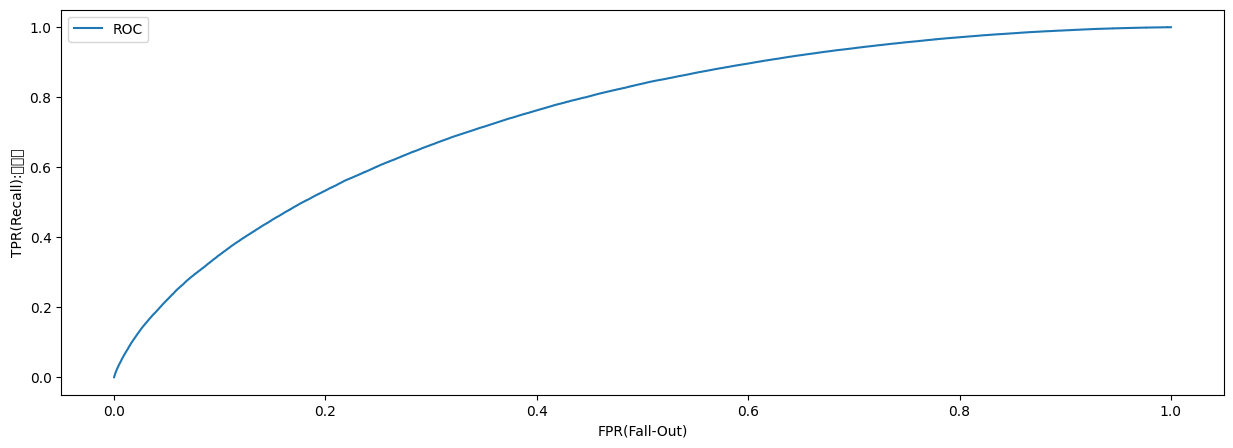

0.7499587386068891

In [31]:
dnn_model.get_roc_auc_score()